<h1 class='font-effect-3d' style='font-family:Akronim; color:#ffcc33;'>✍️ Styling, Links, Helpful Functions, and Modules</h1>

---
#### [GitHub Jupyter Notebook](https://github.com/OlgaBelitskaya/kaggle_notebooks/blob/master/kaggle_image_generator.ipynb) & [Online Version](https://olgabelitskaya.github.io/kaggle_image_generator.html)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=3d'); 
a,h4 {color:slategray; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
span {color:black; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#ffcc33;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}     
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,pylab as pl
from PIL import ImageFile,Image
import math,tensorflow as tf

In [3]:
def get_batches(images,batch_size):
    current_index=0
    while current_index+batch_size<=images.shape[0]:
        data_batch=images[current_index:current_index+batch_size]
        current_index+=batch_size
        yield data_batch/255-.5 
def images_square_grid(images,mode):
    save_size=math.floor(np.sqrt(images.shape[0]))
    images=(((images-images.min())*255)/\
            (images.max()-images.min())).astype(np.uint8)
    images_in_square=np.reshape(images[:save_size*save_size],
                                (save_size,save_size,images.shape[1],
                                 images.shape[2],images.shape[3]))
    if mode=='L':
        images_in_square=np.squeeze(images_in_square,4)
    new_im=Image.new(mode,(images.shape[1]*save_size,
                           images.shape[2]*save_size))
    for col_i,col_images in enumerate(images_in_square):
        for image_i,image in enumerate(col_images):
            im=Image.fromarray(image, mode)
            new_im.paste(im,(col_i*images.shape[1],
                             image_i*images.shape[2]))
    return new_im

<h1 class='font-effect-3d' style='font-family:Akronim; color:#ffcc33;'>✍️  Data</h1>

In [4]:
df_train=pd.read_csv("../input/digit-recognizer/train.csv")
id_images=["%s%s"%("pixel",pixel_no) 
           for pixel_no in range(0,784)]
images=np.array(df_train[id_images])
images=images.astype('float32').reshape(-1,28,28,1)

<h1 class='font-effect-3d' style='font-family:Akronim; color:#ffcc33;'>✍️  NN Model Construction </h1>

In [5]:
stddev=.01; alpha=0.1
learning_rate=.0002; beta1=.5 
z_dim=128; batch_size=32; epochs=3

In [6]:
def nn_inputs(image_width,image_height,image_channels,z_dim):
    input_real=tf.placeholder(tf.float32,name="Real_Input",
                              shape=[None,image_width,
                                     image_height,image_channels]) # rank 4  
    input_z=tf.placeholder(tf.float32,shape=[None,z_dim],
                           name="Z_Input") # rank 2    
    input_learning_rate=tf.placeholder(tf.float32,shape=[],
                                       name="Learning_Rate") # rank 0    
    return input_real,input_z,input_learning_rate


In [7]:
def nn_discriminator(images,reuse=False,alpha=alpha):
    with tf.variable_scope('discriminator',reuse=reuse):
        # image shape [28,28,3]
        x=tf.layers.conv2d(images,32,5,strides=2,padding='same',
                           kernel_initializer=\
                           tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)         
        # input shape [14,14,32]       
        x=tf.layers.conv2d(x,96,5,strides=2,padding='same',
                           kernel_initializer=\
                           tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)        
        x=tf.layers.batch_normalization(x,training=True)
        # input shape [7,7,96]        
        x=tf.layers.conv2d(x,128,5,strides=2,padding='same',
                           kernel_initializer=\
                           tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)       
        x=tf.layers.batch_normalization(x,training=True)
        # input shape [4,4,128]       
        x=tf.reshape(x,(-1,4*4*128))        
        discriminator_logits=tf.layers.dense(x,1)
        discriminator_outputs=tf.sigmoid(discriminator_logits)        
    return discriminator_outputs,discriminator_logits

In [8]:
def nn_generator(z,out_channel_dim,is_train=True,alpha=alpha):
    with tf.variable_scope('generator',reuse=(not is_train)):        
        x=tf.layers.dense(z,7*7*128)
        x=tf.reshape(x,(-1,7,7,128))
        x=tf.maximum(x*alpha,x)          
        x=tf.layers.batch_normalization(x,training=is_train)      
        # input shape [7,7,128]       
        x=tf.layers.conv2d_transpose(x,96,5,strides=2,padding='same',
                                     kernel_initializer=\
                                     tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)          
        x=tf.layers.batch_normalization(x,training=is_train)
        # input shape [14,14,96]
        x=tf.layers.conv2d_transpose(x,32,5,strides=2,padding='same',
                                     kernel_initializer=\
                                     tf.random_normal_initializer(stddev=stddev))
        x=tf.maximum(x*alpha,x)              
        x=tf.layers.batch_normalization(x,training=is_train)
        # input shape [28,28,32]        
        generator_logits=\
        tf.layers.conv2d_transpose(x,out_channel_dim,3,strides=1,padding='same', 
                                   kernel_initializer=\
                                   tf.random_normal_initializer(stddev=stddev))
        # input shape [28,28,3]         
        generator_outputs=tf.tanh(generator_logits)   
    return generator_outputs    

In [9]:
def nn_loss(input_real,input_z,out_channel_dim,
            alpha=alpha,index="leaky_relu"):    
    if index=="relu":
        img_generator=generator(input_z,out_channel_dim,
                                is_train=True,alpha=alpha)
        real_outputs,real_logits=\
        discriminator(input_real,reuse=False,alpha=alpha)
        generator_outputs,generator_logits=\
        discriminator(img_generator,reuse=True,alpha=alpha)
    elif index=="leaky_relu":
        img_generator=nn_generator(input_z,out_channel_dim,
                                   is_train=True,alpha=alpha)
        real_outputs,real_logits=\
        nn_discriminator(input_real,alpha=alpha)
        generator_outputs,generator_logits=\
        nn_discriminator(img_generator,reuse=True,alpha=alpha)          
    real_labels=tf.ones_like(real_outputs)*(1-alpha)
    zeros_labels=tf.zeros_like(generator_outputs)
    ones_labels=tf.ones_like(generator_outputs)
    real_loss=tf.reduce_mean(tf.nn\
    .sigmoid_cross_entropy_with_logits(logits=real_logits,
                                       labels=real_labels))
    zeros_loss=tf.reduce_mean(tf.nn\
    .sigmoid_cross_entropy_with_logits(logits=generator_logits,
                                       labels=zeros_labels))
    ones_loss=tf.reduce_mean(tf.nn\
    .sigmoid_cross_entropy_with_logits(logits=generator_logits,
                                       labels=ones_labels))
    return real_loss+zeros_loss,ones_loss

In [10]:
def nn_optimizer(discriminator_loss,generator_loss,
                 learning_rate,beta1):
    trainable_variables=tf.trainable_variables()
    discriminator_trainable_variables=\
    [v for v in trainable_variables 
     if v.name.startswith('discriminator')]
    generator_trainable_variables=\
    [v for v in trainable_variables 
     if v.name.startswith('generator')]   
    update_ops=tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    discriminator_update_ops=\
    [u for u in update_ops 
     if u.name.startswith('discriminator')]
    generator_update_ops=\
    [u for u in update_ops 
     if u.name.startswith('generator')]
    with tf.control_dependencies(discriminator_update_ops):
        discriminator_training_operations=\
        tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)\
        .minimize(discriminator_loss,
                  var_list=discriminator_trainable_variables)
    with tf.control_dependencies(generator_update_ops):
        generator_training_operations=\
        tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)\
        .minimize(generator_loss,
                  var_list=generator_trainable_variables)           
    return discriminator_training_operations,generator_training_operations

In [11]:
def train(images,epoch_count,batch_size,
          z_dim,learning_rate,beta1, 
          data_shape,data_image_mode,
          print_step,show_step):    
    input_real,input_z,input_learning_rate = \
    nn_inputs(data_shape[1],data_shape[2],
              data_shape[3],z_dim)   
    discriminator_loss,generator_loss=\
    nn_loss(input_real,input_z,data_shape[3],
            alpha=alpha,index="leaky_relu")  
    discriminator_training_operations,generator_training_operations=\
    nn_optimizer(discriminator_loss,generator_loss,
                 learning_rate,beta1)   
    train_step=0; DTL,GTL=[],[]    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(images,batch_size):
                train_step+=1
                batch_images*=2.0                
                batch_z=np.random.uniform(-1,1,size=(batch_size,z_dim))               
                _=sess.run(discriminator_training_operations, 
                           feed_dict={input_real:batch_images,
                                      input_z:batch_z})
                _=sess.run(generator_training_operations, 
                           feed_dict={input_z:batch_z})
                if train_step%print_step==0:
                    discriminator_training_loss=\
                    discriminator_loss.eval({input_real:batch_images,
                                             input_z:batch_z})
                    generator_training_loss=\
                    generator_loss.eval({input_z:batch_z})
                    print("Epoch {}/{}| Step {}|"\
                          .format(epoch_i+1,epochs,train_step),
                          "Discriminator Loss:{:.5f}|"\
                          .format(discriminator_training_loss),
                          "Generator Loss:{:.5f}|"\
                          .format(generator_training_loss),
                          "Discriminator Loss>Generator Loss: {}"\
                          .format(discriminator_training_loss>generator_training_loss))                   
                    DTL.append(discriminator_training_loss) 
                    GTL.append(generator_training_loss)                    
                if train_step%show_step==0:
                    cmap=None if data_image_mode=='RGB' else 'gray'
                    z_dim=input_z.get_shape().as_list()[-1]
                    example_z=np.random.uniform(-1,1,size=[25,z_dim])
                    samples=sess.run(nn_generator(input_z,data_shape[3],False),
                                     feed_dict={input_z:example_z})
                    images_grid=images_square_grid(samples,data_image_mode)
                    pl.figure(figsize=(5,5))
                    pl.imshow(np.array(images_grid),cmap=cmap); pl.show()                            
    pl.figure(figsize=(14,6))
    pl.plot(DTL,label='discriminator')
    pl.plot(GTL,label='generator')
    pl.legend(); pl.title('Loss Function'); pl.show()

<h1 class='font-effect-3d' style='font-family:Akronim; color:#ffcc33;'>✍️ Image Generating </h1>

Epoch 1/3| Step 100| Discriminator Loss:0.36257| Generator Loss:3.99065| Discriminator Loss>Generator Loss: False
Epoch 1/3| Step 200| Discriminator Loss:0.83307| Generator Loss:1.16422| Discriminator Loss>Generator Loss: False
Epoch 1/3| Step 300| Discriminator Loss:0.90252| Generator Loss:0.95289| Discriminator Loss>Generator Loss: False
Epoch 1/3| Step 400| Discriminator Loss:0.75752| Generator Loss:1.85840| Discriminator Loss>Generator Loss: False
Epoch 1/3| Step 500| Discriminator Loss:1.14592| Generator Loss:0.81362| Discriminator Loss>Generator Loss: True
Epoch 1/3| Step 600| Discriminator Loss:1.13035| Generator Loss:0.79182| Discriminator Loss>Generator Loss: True
Epoch 1/3| Step 700| Discriminator Loss:0.97459| Generator Loss:0.93180| Discriminator Loss>Generator Loss: True
Epoch 1/3| Step 800| Discriminator Loss:1.38897| Generator Loss:0.56640| Discriminator Loss>Generator Loss: True
Epoch 1/3| Step 900| Discriminator Loss:1.23030| Generator Loss:0.72893| Discriminator Loss>

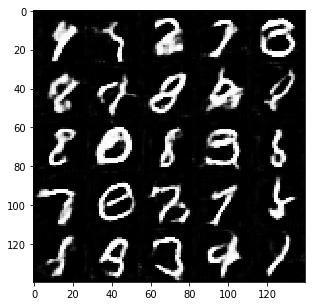

Epoch 1/3| Step 1100| Discriminator Loss:1.01483| Generator Loss:0.83684| Discriminator Loss>Generator Loss: True
Epoch 1/3| Step 1200| Discriminator Loss:0.92580| Generator Loss:1.25087| Discriminator Loss>Generator Loss: False
Epoch 1/3| Step 1300| Discriminator Loss:1.00813| Generator Loss:1.32213| Discriminator Loss>Generator Loss: False
Epoch 2/3| Step 1400| Discriminator Loss:0.98013| Generator Loss:0.89900| Discriminator Loss>Generator Loss: True
Epoch 2/3| Step 1500| Discriminator Loss:1.13623| Generator Loss:0.72013| Discriminator Loss>Generator Loss: True
Epoch 2/3| Step 1600| Discriminator Loss:0.89037| Generator Loss:1.19273| Discriminator Loss>Generator Loss: False
Epoch 2/3| Step 1700| Discriminator Loss:1.03920| Generator Loss:0.91510| Discriminator Loss>Generator Loss: True
Epoch 2/3| Step 1800| Discriminator Loss:0.86293| Generator Loss:1.27984| Discriminator Loss>Generator Loss: False
Epoch 2/3| Step 1900| Discriminator Loss:0.95320| Generator Loss:0.97988| Discrimina

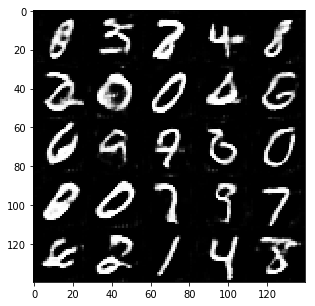

Epoch 2/3| Step 2100| Discriminator Loss:1.18160| Generator Loss:0.68798| Discriminator Loss>Generator Loss: True
Epoch 2/3| Step 2200| Discriminator Loss:1.01405| Generator Loss:0.88800| Discriminator Loss>Generator Loss: True
Epoch 2/3| Step 2300| Discriminator Loss:0.93686| Generator Loss:1.19595| Discriminator Loss>Generator Loss: False
Epoch 2/3| Step 2400| Discriminator Loss:0.67570| Generator Loss:1.72579| Discriminator Loss>Generator Loss: False
Epoch 2/3| Step 2500| Discriminator Loss:0.70424| Generator Loss:1.46576| Discriminator Loss>Generator Loss: False
Epoch 2/3| Step 2600| Discriminator Loss:0.79728| Generator Loss:1.65691| Discriminator Loss>Generator Loss: False
Epoch 3/3| Step 2700| Discriminator Loss:0.93360| Generator Loss:1.02331| Discriminator Loss>Generator Loss: False
Epoch 3/3| Step 2800| Discriminator Loss:0.86291| Generator Loss:1.25047| Discriminator Loss>Generator Loss: False
Epoch 3/3| Step 2900| Discriminator Loss:0.63026| Generator Loss:1.81902| Discrimi

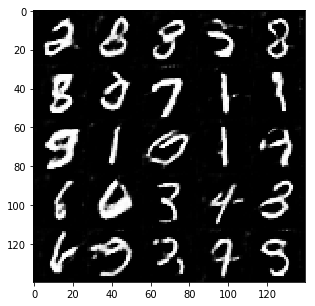

Epoch 3/3| Step 3100| Discriminator Loss:1.13541| Generator Loss:0.86990| Discriminator Loss>Generator Loss: True
Epoch 3/3| Step 3200| Discriminator Loss:1.11737| Generator Loss:1.07398| Discriminator Loss>Generator Loss: True
Epoch 3/3| Step 3300| Discriminator Loss:0.92430| Generator Loss:1.65818| Discriminator Loss>Generator Loss: False
Epoch 3/3| Step 3400| Discriminator Loss:0.70725| Generator Loss:1.36884| Discriminator Loss>Generator Loss: False
Epoch 3/3| Step 3500| Discriminator Loss:1.02952| Generator Loss:0.99935| Discriminator Loss>Generator Loss: True
Epoch 3/3| Step 3600| Discriminator Loss:0.91893| Generator Loss:1.09486| Discriminator Loss>Generator Loss: False
Epoch 3/3| Step 3700| Discriminator Loss:1.43679| Generator Loss:0.53466| Discriminator Loss>Generator Loss: True
Epoch 3/3| Step 3800| Discriminator Loss:1.02278| Generator Loss:0.96370| Discriminator Loss>Generator Loss: True
Epoch 3/3| Step 3900| Discriminator Loss:0.92026| Generator Loss:1.11969| Discriminat

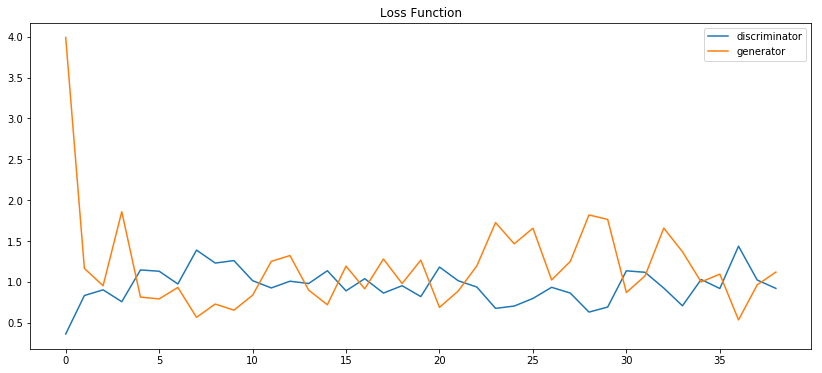

In [12]:
with tf.Graph().as_default():
    train(images,epochs,batch_size, 
          z_dim,learning_rate,beta1, 
          images.shape,"L",100,1000)